# Training Ultralytics YOLOv11 Object Detection on Google Colab

This notebook shows how to train Ultralytics YOLOv11 Object Detector using a custom dataset.

This is done using the Google Colab infrastructure, which provides us some key features like:

- ability to run processes on GPU, essential to be able to train computer vision models.

- storage in Google Drive, where our data will be stored, both the dataset and the checkpoint of the trained model.



# 1. Installing Ultralytics



In [1]:
# Install ultralytics package.

!pip install -qq ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.9/921.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.1 MB/s eta 0:00:00


In [2]:
# Check that the package has been installed
import ultralytics

print(ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
8.3.80


In [3]:
# When the package gets installed we can run the yolo cli command.
# the yolo settings shows us how is the package configured, and some
# important directories paths, like:
# - datasets_dir: where the datasets are expected to be stored, and
# - runs_dir: where the processes are going to store its results
#             (like the resulting training files)

!yolo settings

JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


# 2. Preparing the dataset

In [5]:
# First of all, let's mount Google Drive.
# When running this cell, a pop up will appear asking
# you to grant access to your Google Drive drive.

# This way the training process will be able to store the progress
# into your google drive.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

# TODO:
# Create a folder into your Google Drive.
# This folder will be the working directory.
# Then point the DRIVE_WORKING_DIR variable to the path of this directory.

# In my case is:
DRIVE_WORKING_DIR = "/content/drive/MyDrive/hsicity_proposed_dataet"


In [7]:
# Let's change the working directory
%cd {DRIVE_WORKING_DIR}

/content/drive/MyDrive/hsicity_proposed_dataet


## Custom dataset

I've created a Cats and Dogs dataset, as a subset of the MS COCO dataset, exporting only images with dogs and cats.

You can [download it from kaggle](https://www.kaggle.com/datasets/estebanuriz/cats-and-dogs-for-object-detection/data).

Or you can use your own dataset, the procedure is exactly the same, as long as it is formatted for YOLO.


In [8]:
# I've uploaded the zipped dataset file cats_dogs.zip into my Google Drive folder:
!ls -lh *.zip

ls: cannot access '*.zip': No such file or directory


In [9]:
# decompress the zip to the hard drive instance

# NOTE:
# for training it is faster to place the files into the Colab instance
# hard drive, avoiding network latencies.

!unzip -o -qq cats_dogs.zip -d /content/datasets

unzip:  cannot find or open cats_dogs.zip, cats_dogs.zip.zip or cats_dogs.zip.ZIP.


In [10]:
# dataset files should be on /content/datasets:

!ls /content/datasets/cats_dogs

ls: cannot access '/content/datasets/cats_dogs': No such file or directory


In [8]:
# This script prints the dataset structure in a tree-like format.

import os

def count_files(dir_path, extensions):
    return sum(1 for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f)) and os.path.splitext(f)[1].lower() in extensions)


def count_image_files(dir_path):
    # Define common image extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
    return count_files(dir_path, image_extensions)

def count_label_files(dir_path):
    # Define common label extensions
    label_extensions = {'.txt', '.xml'}
    return count_files(dir_path, label_extensions)

def print_dataset_structure(root_dir, indent="", is_last=True):
    """
      Prints the dataset structure in a tree-like format.

      Inputs:
        root_dir: str (path where a dataset is placed)


    """
    # Print the root directory
    if indent == "":
        print(root_dir)

    # Get sorted directory contents
    items = sorted(os.listdir(root_dir))
    items_count = len(items)

    for i, item in enumerate(items):
        item_path = os.path.join(root_dir, item)
        is_item_last = (i == items_count - 1)  # Check if the item is the last one

        # Determine prefix
        prefix = "└── " if is_item_last else "├── "
        next_indent = indent + ("    " if is_item_last else "│   ")

        if item == ".DS_Store":
            pass

        elif os.path.isdir(item_path):
            # Print directory name
            print(f"{indent}{prefix}{item}")
            # Recurse into subdirectory
            subdirs = sorted(os.listdir(item_path))
            for j, sub in enumerate(subdirs):
                sub_path = os.path.join(item_path, sub)
                if os.path.isdir(sub_path):
                    img_count = count_image_files(sub_path)
                    lbl_count = count_label_files(sub_path)
                    sub_prefix = "└── " if j == len(subdirs) - 1 else "├── "
                    found = []
                    if img_count > 0:
                        found.append(f"{img_count} images")
                    if lbl_count > 0:
                        found.append(f"{lbl_count} labels")
                    if len(found) == 0:
                      count = ""
                    else:
                      count = "[" + ", ".join(found) + "]"
                    print(f"{next_indent}{sub_prefix}{sub} {count}")
        else:
            print(f"{indent}{prefix}{item}")


In [12]:
print_dataset_structure("/content/drive/MyDrive/hsicity_proposed_dataet")

/content/drive/MyDrive/hsicity_proposed_dataet
├── .ipynb_checkpoints
├── dataset.yaml
├── images
│   ├── train [1054 images]
│   └── val [276 images]
├── labels
│   ├── train [1030 labels]
│   ├── val [276 labels]
├── runs
│   └── segment 
├── yolo11n-seg.pt
└── yolo11n.pt


In [9]:
# The data.yaml file, defines some dataset parameters, such as
# split file paths, and classnames:

!cat /content/drive/MyDrive/hsicity_proposed_dataet/dataset.yaml

train: /content/drive/MyDrive/hsicity_proposed_dataet/images/train
val: /content/drive/MyDrive/hsicity_proposed_dataet/images/val
names:
  0: road
  1: sidewalk
  2: building
  3: wall
  4: fence
  5: pole
  6: traffic light
  7: traffic sign
  8: vegetation
  9: terrain
  10: sky
  11: person
  12: rider
  13: car
  14: truck
  15: bus
  16: train
  17: motorcycle
  18: bicycle


## Visualizing Some Examples

When we work with a dataset it is always convenient to visualize some examples to see what they look like.

It is also advisable to check if the labels are correct and are in the format we expect.

The following functions allow us to plot some images and their corresponding labels:

In [9]:
import cv2
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os



In [10]:
def read_labels(file_name):
  """
    Reads a label file
  """

  with open(file_name, "r") as f:
    lines = f.read().splitlines()

  labels = []
  for line in lines:
    label = [float(n) for n in line.split(" ")]
    label = int(label[0]), label[1:]
    labels.append(label)
  return labels


def plot(rgb, labels, class_names=['road','sidewalk','building','wall','fence','pole',
                                   'traffic light','traffic sign','vegetation','terrain',
                                   'sky','person','rider','car','truck','bus','train','motorcycle','bicycle']):
  """
    Given an RGB image and its labels,
    plots the image with the bounding boxes.
  """

  plt.figure(figsize=(18, 8))
  plt.imshow(rgb)

  img_w, img_h = rgb.shape[1], rgb.shape[0]

  ax = plt.gca()
  for label in labels:
    class_id, bbox = label
    cx, cy, w, h = bbox

    cx = img_w * cx
    cy = img_h * cy
    w = img_w * w
    h = img_h * h

    hw = w / 2
    hh = h / 2

    pt = (cx - hw, cy - hh)

    if class_id == 0:
      color = 'blue'
    else:
      color = 'red'

    ax.add_patch(Rectangle(
        pt, w, h,
        edgecolor = color,
        fill=None
    ))

    # Add class label above the bounding box
    label_text = class_names[int(class_id)]
    label_position = (cx - hw, cy - hh - 5)  # Slightly above the bbox
    ax.text(
      label_position[0], label_position[1],
      label_text,
      color=color,
      fontsize=12,
      fontweight='bold',
      bbox=dict(facecolor='white', edgecolor=color, alpha=0.7)
    )


  plt.show()

In [11]:
import glob
import numpy as np

def sample_some(
    data_root,
    split=None,
    n=10,
    seed=1234
):
  """

    Randomly samples a specified number of label and corresponding image files from a dataset.

    Parameters:
    -----------
    data_root : str.
        The root directory of the dataset.
    split : str, optional
        The split or subfolder within the `labels` directory to sample from. Defaults to `None`,
        which matches all subdirectories (i.e., "**").
    n : int, optional
        The number of label files to sample. Defaults to 10.
    seed : int, optional
        The random seed for reproducibility. Defaults to 1234.

    Returns:
    --------
    img_files : list of str
        A list of file paths to the corresponding image files in the `images` subdirectory.
    lbl_files : list of str
        A list of file paths to the sampled label files in the `labels` subdirectory.

    """

  np.random.seed(seed)

  if split is None:
    split = "**"

  pattern = os.path.join(data_root, f"labels/{split}/*.txt")
  label_files = sorted(glob.glob(pattern))

  lbl_files = np.random.choice(label_files, n, replace=False)
  lbl_files = list(lbl_files)

  img_files = [
      f.replace("labels", "images").replace(".txt", ".png")
      for f in lbl_files
  ]

  return img_files, lbl_files


In [12]:
img_files, lbl_files = sample_some(
    data_root="/content/drive/MyDrive/hsicity_proposed_dataet",
    split="val",
    n=3,
    seed=42
)

In [13]:
img_files

['/content/drive/MyDrive/hsicity_proposed_dataet/images/val/20210409_143420_01.png',
 '/content/drive/MyDrive/hsicity_proposed_dataet/images/val/20210409_170324_03.png',
 '/content/drive/MyDrive/hsicity_proposed_dataet/images/val/20210410_113423_02.png']

In [14]:
lbl_files

['/content/drive/MyDrive/hsicity_proposed_dataet/labels/val/20210409_143420_01.txt',
 '/content/drive/MyDrive/hsicity_proposed_dataet/labels/val/20210409_170324_03.txt',
 '/content/drive/MyDrive/hsicity_proposed_dataet/labels/val/20210410_113423_02.txt']

In [20]:
# choose some random files
# data_root = "/content/drive/MyDrive/hsicity_proposed_dataet"
# samples = sample_some(data_root, split='val')

# for image_file, label_file in zip(*samples):
#   image = cv2.imread(image_file)
#   rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   labels = read_labels(label_file)

#   for label in labels:
#     class_id, bbox = label
#     print(f"class_id: {class_id}, bbox: {bbox}")

#   plot(rgb, labels)


# 3. Training the model

Training the model requires intensive computation provided by GPUs. Theoretically we can train on CPU but it would take a long time. Therefore it is important to have a GPU to train. However, for data preparation and evaluation of results we can use CPU which is much less expensive. Therefore, the recommendation is to use GPU only during training.

In [15]:
import torch

cuda_available = torch.cuda.is_available()

if cuda_available:

  print("CUDA is available")
  !nvidia-smi

else:

  message = """
    WARNING: In order to train the model, it is advisable to use GPU.
    Change runtime type to GPU from:
      menu Runtime -> Change runtime type -> Hardware accelerator -> GPU.
      And run all the cells again.
  """
  print(message)

CUDA is available
Thu Feb 27 18:01:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------

In [16]:
!pwd

/content/drive/MyDrive/hsicity_proposed_dataet


In [17]:
def serialized_model_file(
    checkpoint="best",
    use_run="train",
):
  """
    Returns the serialized file path.
  """
  return f"runs/detect/{use_run}/weights/{checkpoint}.pt"


In [25]:
# model = YOLO("/content/drive/MyDrive/hsicity_proposed_dataet/yolo11n-seg.pt")
# results = model.predict(source="/content/drive/MyDrive/hsicity_proposed_dataet/images/val/20210409_140722_03.png", conf=0.25)[0]


image 1/1 /content/drive/MyDrive/hsicity_proposed_dataet/images/val/20210409_140722_03.png: 512x640 8 cars, 1 traffic light, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


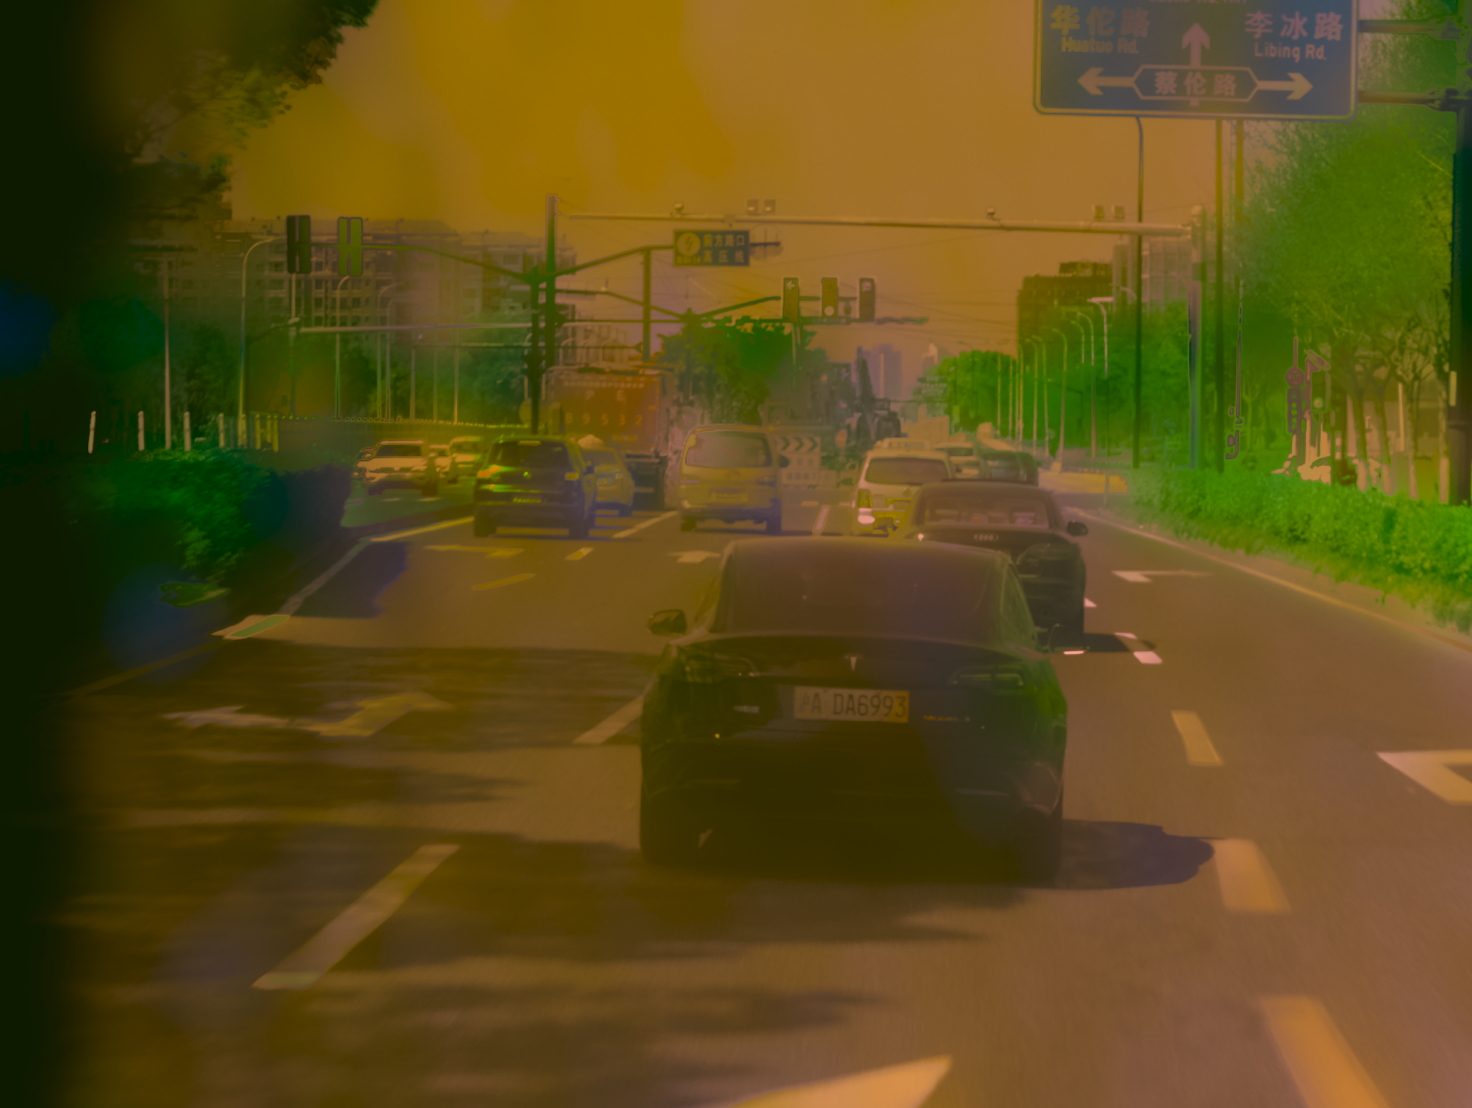

In [24]:
# from IPython.display import Image as IPyImage

# IPyImage(filename=f'/content/drive/MyDrive/hsicity_proposed_dataet/images/val/20210409_140722_03.png', width=600)

In [30]:
# from PIL import Image
# import requests
# image = Image.open('/content/drive/MyDrive/hsicity_proposed_dataet/images/val/20210409_140722_03.png')

In [27]:
# !pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.4 MB/s eta 0:00:00


In [28]:
# import supervision as sv

# detections = sv.Detections.from_ultralytics(results)

In [34]:
# mask_annotator = sv.MaskAnnotator()
# label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_position=sv.Position.CENTER)

# annotated_image = image.copy()
# annotated_image = mask_annotator.annotate(annotated_image, detections=detections)
# annotated_image = label_annotator.annotate(annotated_image, detections=detections)

# sv.plot_image(annotated_image, size=(10, 10))

In [18]:
import os
from ultralytics import YOLO

def train(
    data,
    use_run="train",
    fallback="yolo11n-seg.yaml",
    #fallback="yolo11n-seg.pt",
    epochs=100,
    augment=True,
):

  cuda_available = torch.cuda.is_available()
  if not cuda_available:
    print("CUDA is not available, skipping train.")
    return

  model_file = serialized_model_file("last", use_run)

  if os.path.exists(model_file):
    resume_training = True
    use_model = model_file
  else:
    resume_training = False
    use_model=fallback


  model = YOLO(
      use_model
  )

  model.train(
      data=data,
      resume=resume_training,
      epochs=epochs,
      optimizer="AdamW",
      lr0=0.0001,
      imgsz=320,
      batch=64,
      augment=augment
  )


In [ ]:
train(data="/content/drive/MyDrive/hsicity_proposed_dataet/dataset.yaml", use_run=None)

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.yaml, data=/content/drive/MyDrive/hsicity_proposed_dataet/dataset.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]


Overriding model.yaml nc=80 with nc=19

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/drive/MyDrive/hsicity_proposed_dataet/labels/train.cache... 575 images, 23 backgrounds, 456 corrupt: 100%|██████████| 1054/1054 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/hsicity_proposed_dataet/images/train/20210409_144957_01.png: ignoring corrupt image/label: broken PNG file (bad header checksum in b'IDAT')
train: WARNING ⚠️ /content/drive/MyDrive/hsicity_proposed_dataet/images/train/20210409_162442_00.png: ignoring corrupt image/label: broken PNG file (bad header checksum in b'IDAT')
train: WARNING ⚠️ /content/drive/MyDrive/hsicity_proposed_dataet/images/train/20210410_103944_03.png: ignoring corrupt image/label: broken PNG file (bad header checksum in b'IDAT')
train: WARNING ⚠️ /content/drive/MyDrive/hsicity_proposed_dataet/images/train/20210410_104002_02.png: ignoring corrupt image/label: broken PNG file (bad header checksum in b'IDAT')
train: WARNING ⚠️ /content/drive/MyDrive/hsicity_proposed_dataet/images/train/20210410_104007_01.png: ignoring corrupt image/label: broken PNG file (bad header checksum in b'IDAT')
train: WARNING ⚠️ /content/drive/MyDrive/hsicity_proposed_dataet/images/train/20210410_104019_0

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/hsicity_proposed_dataet/labels/val.cache... 276 images, 0 backgrounds, 0 corrupt: 100%|██████████| 276/276 [00:00<?, ?it/s]


Plotting labels to runs/segment/train6/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/segment/train6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.56G      4.427      8.479      5.098      4.228        762        320: 100%|██████████| 10/10 [03:37<00:00, 21.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

                   all        276      18647          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.89G      4.282      7.083      4.772      3.876        796        320: 100%|██████████| 10/10 [01:16<00:00,  7.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        276      18647          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.97G      4.122      5.072      4.054      3.268        907        320: 100%|██████████| 10/10 [01:02<00:00,  6.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.58s/it]


                   all        276      18647   0.000606     0.0136   0.000345   0.000131   0.000344    0.00924   0.000191   5.08e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.22G      4.161      4.862      3.625      2.939        704        320: 100%|██████████| 10/10 [00:59<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


                   all        276      18647   0.000604     0.0126   0.000362   0.000131   0.000355    0.00901   0.000201   4.74e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.48G      4.174      4.828      3.524      2.753        923        320: 100%|██████████| 10/10 [00:54<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.13s/it]


                   all        276      18647   0.000537     0.0111    0.00031    0.00011   0.000337    0.00833   0.000185    4.2e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.77G      4.126      4.833      3.512      2.695        850        320: 100%|██████████| 10/10 [00:55<00:00,  5.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.94s/it]


                   all        276      18647   0.000602     0.0124   0.000362   0.000133   0.000353    0.00876   0.000202    4.7e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.56G      4.059      4.818      3.493      2.649        852        320: 100%|██████████| 10/10 [00:53<00:00,  5.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.78s/it]


                   all        276      18647   0.000624     0.0131   0.000446   0.000152   0.000342    0.00869    0.00021   5.07e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.75G      4.039      4.797      3.481      2.621       1116        320: 100%|██████████| 10/10 [00:55<00:00,  5.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.55s/it]


                   all        276      18647   0.000628     0.0135    0.00044   0.000153   0.000358     0.0092   0.000213   5.02e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.85G      3.974      4.816      3.463      2.576        970        320: 100%|██████████| 10/10 [00:52<00:00,  5.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


                   all        276      18647   0.000633     0.0135   0.000417   0.000148    0.00037    0.00957   0.000212   4.95e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.64G      3.946        4.8      3.437      2.559        855        320: 100%|██████████| 10/10 [00:52<00:00,  5.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.22s/it]


                   all        276      18647     0.0011     0.0171   0.000702   0.000259   0.000514     0.0107   0.000297   6.63e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.47G      3.914      4.796      3.443      2.526        884        320: 100%|██████████| 10/10 [00:54<00:00,  5.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.92s/it]


                   all        276      18647    0.00383     0.0208    0.00219    0.00073    0.00121     0.0122   0.000675   0.000139

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.95G      3.885      4.794      3.387      2.506        832        320: 100%|██████████| 10/10 [00:52<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.96s/it]


                   all        276      18647    0.00459     0.0227    0.00287   0.000972    0.00157     0.0133   0.000965    0.00019

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.86G       3.86      4.773      3.395      2.488        791        320: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.78s/it]


                   all        276      18647    0.00543     0.0228    0.00428    0.00149    0.00177      0.014     0.0013   0.000243

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100       3.2G      3.826      4.765       3.37      2.472        780        320: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.90s/it]


                   all        276      18647    0.00483     0.0241    0.00417    0.00146    0.00207     0.0151    0.00153    0.00029

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.77G      3.825      4.756      3.349      2.447        781        320: 100%|██████████| 10/10 [00:54<00:00,  5.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.79s/it]


                   all        276      18647    0.00422     0.0256    0.00437    0.00159    0.00202     0.0149    0.00158   0.000318

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.51G      3.781      4.751      3.348      2.431        707        320: 100%|██████████| 10/10 [00:52<00:00,  5.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.79s/it]


                   all        276      18647    0.00466     0.0265    0.00467    0.00175    0.00228     0.0139    0.00169   0.000368

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.52G      3.764      4.746      3.314      2.413        965        320: 100%|██████████| 10/10 [00:55<00:00,  5.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.91s/it]


                   all        276      18647     0.0703     0.0146    0.00863    0.00247    0.00978     0.0146     0.0055   0.000929

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.69G       3.73      4.738      3.289      2.397        886        320: 100%|██████████| 10/10 [00:53<00:00,  5.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.06s/it]


                   all        276      18647     0.0689     0.0179    0.00864    0.00215    0.00932     0.0163     0.0056      0.001

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.65G      3.723       4.72       3.29      2.391       1015        320: 100%|██████████| 10/10 [00:51<00:00,  5.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


                   all        276      18647      0.069     0.0188     0.0103    0.00265    0.00944     0.0179    0.00597    0.00138

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.89G      3.675      4.701      3.271      2.381        614        320: 100%|██████████| 10/10 [00:54<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.71s/it]


                   all        276      18647     0.0829     0.0101    0.00844    0.00245      0.136    0.00522    0.00529    0.00109

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100       3.5G      3.646      4.683      3.247      2.352        822        320: 100%|██████████| 10/10 [00:52<00:00,  5.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.98s/it]


                   all        276      18647      0.154    0.00907    0.00997    0.00281      0.133    0.00473    0.00574    0.00149

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.68G      3.621      4.656      3.231      2.336        798        320: 100%|██████████| 10/10 [00:52<00:00,  5.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.90s/it]


                   all        276      18647      0.155    0.00982    0.00935    0.00288     0.0774    0.00752     0.0056    0.00145

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.63G      3.598      4.669      3.257      2.334        721        320: 100%|██████████| 10/10 [00:52<00:00,  5.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.94s/it]


                   all        276      18647      0.155     0.0107     0.0105     0.0033      0.142    0.00706    0.00603    0.00167

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.68G      3.577      4.646      3.213      2.319        697        320: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.33s/it]


                   all        276      18647       0.15     0.0114      0.011    0.00341      0.143    0.00866    0.00792    0.00201

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.57G      3.549      4.632      3.171        2.3        705        320: 100%|██████████| 10/10 [00:51<00:00,  5.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.01s/it]


                   all        276      18647       0.15     0.0125      0.011    0.00372      0.142    0.00913    0.00797     0.0021

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.45G      3.535      4.634      3.181      2.293        802        320: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.01s/it]


                   all        276      18647      0.151      0.013     0.0114    0.00374      0.142    0.00974    0.00791    0.00208

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100       3.7G      3.537      4.623      3.156      2.278        887        320: 100%|██████████| 10/10 [00:55<00:00,  5.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


                   all        276      18647      0.148     0.0128     0.0113    0.00371      0.146     0.0104    0.00916    0.00237

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.97G      3.511      4.609      3.134      2.251       1073        320: 100%|██████████| 10/10 [00:50<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.14s/it]


                   all        276      18647      0.147     0.0126     0.0114    0.00371      0.144     0.0103    0.00902    0.00232

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.86G      3.489      4.594      3.135      2.248        824        320: 100%|██████████| 10/10 [00:51<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.95s/it]


                   all        276      18647     0.0899     0.0131     0.0119    0.00393      0.152     0.0112    0.00965    0.00252

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.58G      3.504      4.582      3.114       2.26        863        320: 100%|██████████| 10/10 [00:53<00:00,  5.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


                   all        276      18647     0.0906      0.013      0.012    0.00407       0.15     0.0114    0.00988    0.00277

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.71G      3.452      4.569      3.112      2.235        993        320: 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.01s/it]


                   all        276      18647      0.118     0.0134     0.0127    0.00423     0.0909     0.0118     0.0105    0.00299

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.68G      3.472      4.592      3.088      2.218       1135        320: 100%|██████████| 10/10 [00:52<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.92s/it]


                   all        276      18647      0.102     0.0142     0.0129    0.00435     0.0897      0.012     0.0105    0.00307

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.96G      3.444      4.563      3.095       2.22        810        320: 100%|██████████| 10/10 [00:51<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


                   all        276      18647     0.0958     0.0136     0.0134    0.00456     0.0921     0.0123     0.0116    0.00331

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.88G      3.446      4.558        3.1      2.223        788        320: 100%|██████████| 10/10 [00:51<00:00,  5.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.97s/it]


                   all        276      18647     0.0972     0.0139     0.0135    0.00445     0.0886     0.0123     0.0109    0.00308

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.56G      3.427      4.569      3.066      2.206        938        320: 100%|██████████| 10/10 [00:52<00:00,  5.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.27s/it]


                   all        276      18647     0.0974     0.0149     0.0142    0.00489     0.0912     0.0132     0.0115    0.00341

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.65G      3.393      4.536      3.042      2.192        788        320: 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.96s/it]


                   all        276      18647     0.0971     0.0156     0.0149    0.00511     0.0917     0.0136     0.0117    0.00355

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.43G      3.399      4.563      3.071       2.19        707        320: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.87s/it]


                   all        276      18647     0.0908     0.0149     0.0132    0.00442     0.0894     0.0137     0.0117     0.0033

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.85G      3.362      4.521      3.037      2.186        749        320: 100%|██████████| 10/10 [00:52<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.93s/it]


                   all        276      18647     0.0959     0.0152     0.0145    0.00494     0.0937     0.0132     0.0117     0.0034

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.88G      3.369      4.544      3.041      2.181        737        320: 100%|██████████| 10/10 [00:52<00:00,  5.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.88s/it]


                   all        276      18647     0.0944     0.0159     0.0145    0.00491     0.0864      0.013     0.0111    0.00326

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.99G       3.35      4.541      3.017      2.168        811        320: 100%|██████████| 10/10 [00:54<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.01s/it]


                   all        276      18647     0.0951     0.0163     0.0149      0.005     0.0921     0.0141     0.0133    0.00387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.72G      3.323      4.516      2.994      2.163        649        320: 100%|██████████| 10/10 [00:50<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


                   all        276      18647     0.0948     0.0162     0.0143    0.00486     0.0923     0.0144     0.0131    0.00379

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.48G      3.335      4.531      2.989       2.16        943        320: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.83s/it]


                   all        276      18647     0.0958     0.0167     0.0147    0.00522     0.0916     0.0146     0.0124     0.0035

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.67G      3.297      4.488       2.99      2.145        855        320: 100%|██████████| 10/10 [00:52<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.94s/it]


                   all        276      18647     0.0949     0.0172     0.0147     0.0054     0.0662     0.0148     0.0123    0.00369

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.58G      3.314      4.521      2.985      2.152        787        320: 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.80s/it]


                   all        276      18647     0.0721     0.0175     0.0145    0.00502     0.0658     0.0153      0.013    0.00387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.57G      3.286      4.506      2.962      2.136        873        320: 100%|██████████| 10/10 [00:53<00:00,  5.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.88s/it]


                   all        276      18647     0.0466      0.017      0.015    0.00531     0.0955     0.0154     0.0126     0.0037

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.55G      3.316        4.5      2.941       2.13        995        320: 100%|██████████| 10/10 [00:52<00:00,  5.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  5.00s/it]


                   all        276      18647     0.0761     0.0171     0.0148    0.00511     0.0722     0.0159      0.013    0.00374

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100       3.9G      3.293        4.5      2.945      2.131        919        320: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.72s/it]


                   all        276      18647     0.0579     0.0165     0.0143    0.00464     0.0627     0.0158     0.0141    0.00396

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.52G      3.271       4.48      2.922      2.118        947        320: 100%|██████████| 10/10 [00:53<00:00,  5.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


                   all        276      18647     0.0701     0.0179     0.0149    0.00524     0.0648     0.0164     0.0142    0.00416

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.73G      3.274      4.503      2.931       2.11        759        320: 100%|██████████| 10/10 [00:56<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.89s/it]


                   all        276      18647     0.0615     0.0178     0.0154     0.0055     0.0633     0.0164     0.0133     0.0039

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.22G      3.247      4.468      2.921      2.106        892        320: 100%|██████████| 10/10 [00:55<00:00,  5.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.77s/it]


                   all        276      18647     0.0687     0.0179     0.0157    0.00555     0.0575     0.0161     0.0138    0.00407

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.67G      3.259       4.46      2.922      2.105        685        320: 100%|██████████| 10/10 [00:52<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.89s/it]


                   all        276      18647      0.112     0.0176     0.0152     0.0053      0.122     0.0165     0.0146    0.00406

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.66G      3.276      4.465      2.917      2.111        803        320: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.67s/it]


                   all        276      18647      0.111     0.0181     0.0157    0.00557      0.123     0.0171     0.0143    0.00421

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.58G      3.231      4.504      2.928      2.097        824        320: 100%|██████████| 10/10 [00:51<00:00,  5.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.81s/it]


                   all        276      18647      0.123     0.0193     0.0165    0.00594      0.124     0.0174     0.0136    0.00407

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100       3.2G      3.253      4.468      2.932      2.104        887        320: 100%|██████████| 10/10 [00:53<00:00,  5.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.60s/it]


                   all        276      18647      0.123     0.0189     0.0159    0.00592      0.125      0.017     0.0135      0.004

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.3G      3.232      4.445      2.919      2.103        627        320: 100%|██████████| 10/10 [00:52<00:00,  5.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.72s/it]


                   all        276      18647      0.123     0.0193     0.0157    0.00541      0.125     0.0181      0.015    0.00437

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.77G      3.214       4.47      2.894      2.087        884        320: 100%|██████████| 10/10 [00:51<00:00,  5.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.91s/it]


                   all        276      18647      0.121     0.0201     0.0154    0.00548      0.124     0.0187     0.0145    0.00417

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.24G      3.231      4.484      2.905      2.094        875        320: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.91s/it]


                   all        276      18647      0.118     0.0202     0.0161    0.00599      0.123     0.0187     0.0144    0.00444

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.71G      3.225       4.44      2.877      2.083        925        320: 100%|██████████| 10/10 [00:52<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.77s/it]


                   all        276      18647      0.122     0.0204     0.0166    0.00601      0.126     0.0185      0.015     0.0047

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.87G      3.218      4.458      2.901      2.078        758        320: 100%|██████████| 10/10 [00:52<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.06s/it]


                   all        276      18647      0.118     0.0202     0.0166    0.00618      0.123     0.0183     0.0142    0.00447

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.58G      3.197      4.468      2.881      2.069        842        320: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.01s/it]


                   all        276      18647       0.12     0.0201      0.017    0.00629      0.126     0.0188     0.0187    0.00488

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100       3.2G      3.188      4.416      2.887      2.067        889        320: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.88s/it]


                   all        276      18647      0.121     0.0195     0.0168    0.00626      0.125     0.0182     0.0154     0.0048

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.01G      3.189      4.459      2.871      2.067        785        320: 100%|██████████| 10/10 [00:59<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.86s/it]


                   all        276      18647      0.122     0.0195     0.0168    0.00601      0.128     0.0187     0.0175    0.00503

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.55G       3.16      4.424      2.848      2.063        693        320: 100%|██████████| 10/10 [00:53<00:00,  5.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.69s/it]


                   all        276      18647      0.118     0.0195     0.0166    0.00606      0.122     0.0186     0.0168     0.0048

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.75G      3.161      4.411      2.854      2.063        674        320: 100%|██████████| 10/10 [00:52<00:00,  5.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.96s/it]


                   all        276      18647      0.121     0.0198     0.0165    0.00597      0.127     0.0187     0.0153    0.00454

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.72G      3.156       4.42       2.84      2.054        634        320: 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.49s/it]


                   all        276      18647      0.119     0.0193     0.0159    0.00562      0.126     0.0186     0.0158    0.00469

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.62G      3.159      4.417      2.833      2.054        806        320: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.80s/it]


                   all        276      18647      0.118     0.0192     0.0166    0.00613      0.122     0.0185     0.0162     0.0048

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.21G      3.157      4.405      2.836      2.054        809        320: 100%|██████████| 10/10 [00:50<00:00,  5.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.69s/it]


                   all        276      18647      0.119     0.0195     0.0166    0.00613      0.122     0.0186     0.0159    0.00453

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.68G      3.151      4.416      2.824       2.05        819        320: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.58s/it]


                   all        276      18647      0.181     0.0199     0.0171    0.00638      0.182     0.0187     0.0166    0.00474

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.64G      3.143       4.44      2.835      2.055        676        320: 100%|██████████| 10/10 [00:54<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]


                   all        276      18647      0.183     0.0208     0.0179    0.00669      0.183     0.0193     0.0164    0.00496

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.19G      3.148      4.443      2.822      2.032        819        320: 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.68s/it]


                   all        276      18647      0.182     0.0208     0.0189    0.00701      0.183     0.0198     0.0174    0.00527

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.39G      3.147      4.431      2.844      2.036       2447        320:  80%|████████  | 8/10 [00:40<00:10,  5.12s/it]

In [ ]:
import locale
def getpreferredencoding():
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8

In [ ]:
!yolo settings

# 4. Reviewing Training Results

After training we will find some resulting files into the runs directory:

## checking results into the "runs" directory

Ultralytics package creates the "runs" directory, where the results are stored. Since we are training an object detector, the detect/train directory is created:

If we train again with different configurations, new directories train2, train3, train4… will be created, unless we resume training. If we resume training, the corresponding directories are re-used.

In [ ]:
!ls -l runs/segment/train

### Training history

we can observe, a sharp worsening jump in the loss curves, and after that the model starts improving. One possible explanation is as follows: My dataset is a sub-set of COCO, the pre-trained weights at start were created  using the same images, so the model already knew how to detect cats and dogs. Surely I started with a very high learning rate, destroying the previous learned knowledge? Should I start with a much lower learning rate? or perhaps should I freeze the first layers, to avoid this effect and achieve much faster convergence?

In [ ]:

from PIL import Image

Image.open("runs/segment/train/results.png")

### args.yaml

Into the `args.yaml` file we can check the running arguments, like total number of epochs, enabled augmentations, etc.

Check its contents to see which parameters were used for this experiment.

In [ ]:
!cat runs/segment/train/args.yaml

### checkpoint files

On the weights directory we can find the PyTorch serialized checkpoints files:
- best.pt
- last.pt

These files contain the model weights as well as the training state, so that we can continue training from these serialized files. Use last.pt for continue training, and best.pt for production.

In [ ]:
!ls -lh runs/segment/train/weights

### Batch visualizations

The files like `train_batch#.jpg` and `val_batch_pred#.jpg` are grids of batch images and its corresponding bounding boxes:

#### Training Visualization
here is a training batch visualization.
Note the applied augmentation transformations like mosaic, flip, and intensities shifts.

In [ ]:

Image.open("runs/segment/train/train_batch0.jpg")


#### Validation Visualization
here is a validation batch visualization. We can see the predicted bounding boxes, each one with its corresponding class and prediction confidence.

In [ ]:
Image.open("runs/segment/train/val_batch0_pred.jpg")

### PR_curve.png

Precision-Recall plot which helps us evaluate the object detector by showing the trade-off between precision and recall across different thresholds.

By analyzing the PR curve, we can choose confidence thresholds that align with the specific goals of your application, such as prioritizing precision (e.g., for safety-critical tasks) or recall (e.g., for exhaustive search tasks).


In [ ]:
Image.open("runs/segment/train/PR_curve.png")

### confusion_matrix.png

A confusion matrix in object detection is useful for analyzing how well the model distinguishes between object classes (e.g., cat vs. dog) and background, highlighting misclassifications and false positives/negatives at a glance.

By analyzing the confusion matrix, you can pinpoint which classes are most problematic, evaluate the balance between precision and recall, and identify areas where the model might need improvement, such as adjusting thresholds, augmenting the dataset, or fine-tuning the training process.

In this case, with a simple glance we see that the weakest point of the model is its False Negatives, that is, cases where the model claims that there are cats or dogs, but according to the labels, they are not really there.

In [ ]:
Image.open("runs/segment/train/confusion_matrix.png")

## Testing the model

In [ ]:
!pwd

### Predicting via cli


In [ ]:
# !yolo detect predict model=runs/detect/train/weights/best.pt source=/content/datasets/cats_dogs/images/val/000000547502.jpg

In [ ]:
# from PIL import Image
# Image.open("runs/segment/predict4/000000547502.jpg")

### Predicting using Python

#### Load the best.pt model

In [ ]:
from ultralytics import YOLO

# Load the best model we have so far:
model_file = serialized_model_file("best")
print(f"loading checkpoint {model_file}")
model = YOLO(model_file)


#### Ploting the results using matlab

Ultralytics provide tools for plotting the results, but in a real-world application we'll want to use the prediction results programmatically.

The following code reads prediction results, its bounding boxes and plots them using matplotlib.


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

def convert_to_pixel_coords(box, img_width, img_height):
    """
    Convert YOLO format box (cx, cy, w, h) to pixel coordinates.
    """
    return [
        box[0] * img_width,  # cx
        box[1] * img_height, # cy
        box[2] * img_width,  # w
        box[3] * img_height  # h
    ]

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Boxes are in the format (cx, cy, w, h).
    """
    # Convert (cx, cy, w, h) to (x1, y1, x2, y2)
    x1_box1, y1_box1 = box1[0] - box1[2] / 2, box1[1] - box1[3] / 2
    x2_box1, y2_box1 = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2

    x1_box2, y1_box2 = box2[0] - box2[2] / 2, box2[1] - box2[3] / 2
    x2_box2, y2_box2 = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2

    # Calculate intersection
    inter_x1 = max(x1_box1, x1_box2)
    inter_y1 = max(y1_box1, y1_box2)
    inter_x2 = min(x2_box1, x2_box2)
    inter_y2 = min(y2_box1, y2_box2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Calculate union
    box1_area = (x2_box1 - x1_box1) * (y2_box1 - y1_box1)
    box2_area = (x2_box2 - x1_box2) * (y2_box2 - y1_box2)

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def plot_result(rgb, result, label=None, iou_threshold=0.5):
    """
    Plot YOLO prediction results and compare with ground truth labels if provided.

    Parameters:
      - rgb: numpy array of the RGB image.
      - result: YOLO prediction result.
      - label: Optional ground truth labels [(class_id, [cx, cy, w, h]), ...].
      - iou_threshold: IoU threshold to match predictions with ground truth.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rgb)

    class_names = result.names
    height, width, _ = rgb.shape

    predictions = result.boxes.xywh.cpu().numpy()
    pred_classes = result.boxes.cls.cpu().numpy()

    gt_used = [False] * len(label) if label else []

    for i, pred_box in enumerate(predictions):
        pred_class_id = int(pred_classes[i])
        pred_box = pred_box.tolist()
        matched = False

        if label:
            for j, (gt_class_id, gt_box) in enumerate(label):
                if not gt_used[j] and gt_class_id == pred_class_id:
                    # Convert ground truth box to pixel values
                    gt_box_pixel = convert_to_pixel_coords(gt_box, width, height)
                    iou = calculate_iou(pred_box, gt_box_pixel)
                    if iou >= iou_threshold:
                        matched = True
                        gt_used[j] = True
                        break

        color = 'green' if matched else 'red'
        cx, cy, w, h = pred_box
        hw, hh = w / 2, h / 2

        ax.add_patch(Rectangle(
            (cx - hw, cy - hh), w, h,
            edgecolor=color,
            fill=None,
            linewidth=2
        ))

        label_text = f"{class_names[pred_class_id]} ({iou:.2f})" if matched else class_names[pred_class_id]
        ax.text(
            cx - hw, cy - hh - 5,
            label_text,
            color=color,
            fontsize=10,
            fontweight='bold',
            bbox=dict(facecolor='white', edgecolor=color, alpha=0.7)
        )

    if label:
        for gt_class_id, gt_box in label:
            # Convert ground truth box to pixel values
            gt_box_pixel = convert_to_pixel_coords(gt_box, width, height)
            cx, cy, w, h = gt_box_pixel
            hw, hh = w / 2, h / 2

            ax.add_patch(Rectangle(
                (cx - hw, cy - hh), w, h,
                edgecolor='blue',
                fill=None,
                linestyle='--',
                linewidth=1
            ))

    plt.show()


In [ ]:
samples = sample_some(
    data_root="/content/datasets/cats_dogs",
    split="val",
    seed=42,
    n=16
)


In [ ]:
for image_file, labels_file in zip(*samples):

    img = cv2.imread(image_file)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    labels = read_labels(labels_file)
    result = model.predict(rgb, conf=0.5, iou=0.3)[0]

    plot_result(rgb, result, labels)